# **importing the necessary Libraries**

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import layers, models,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report



# **Loading  image dataset and  Data Preprocessing / Preparation**

In [3]:
# Constants

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 6
DATASET_PATH = '/content/drive/MyDrive/DATASET/Train'
TEST_DATABASE='/content/drive/MyDrive/DATASET/Test'


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True

)


train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
)

val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_DATABASE,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)


val_class= val_generator.class_indices

print(val_class)


Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
Found 3048 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


# Visualize sample images from each class.


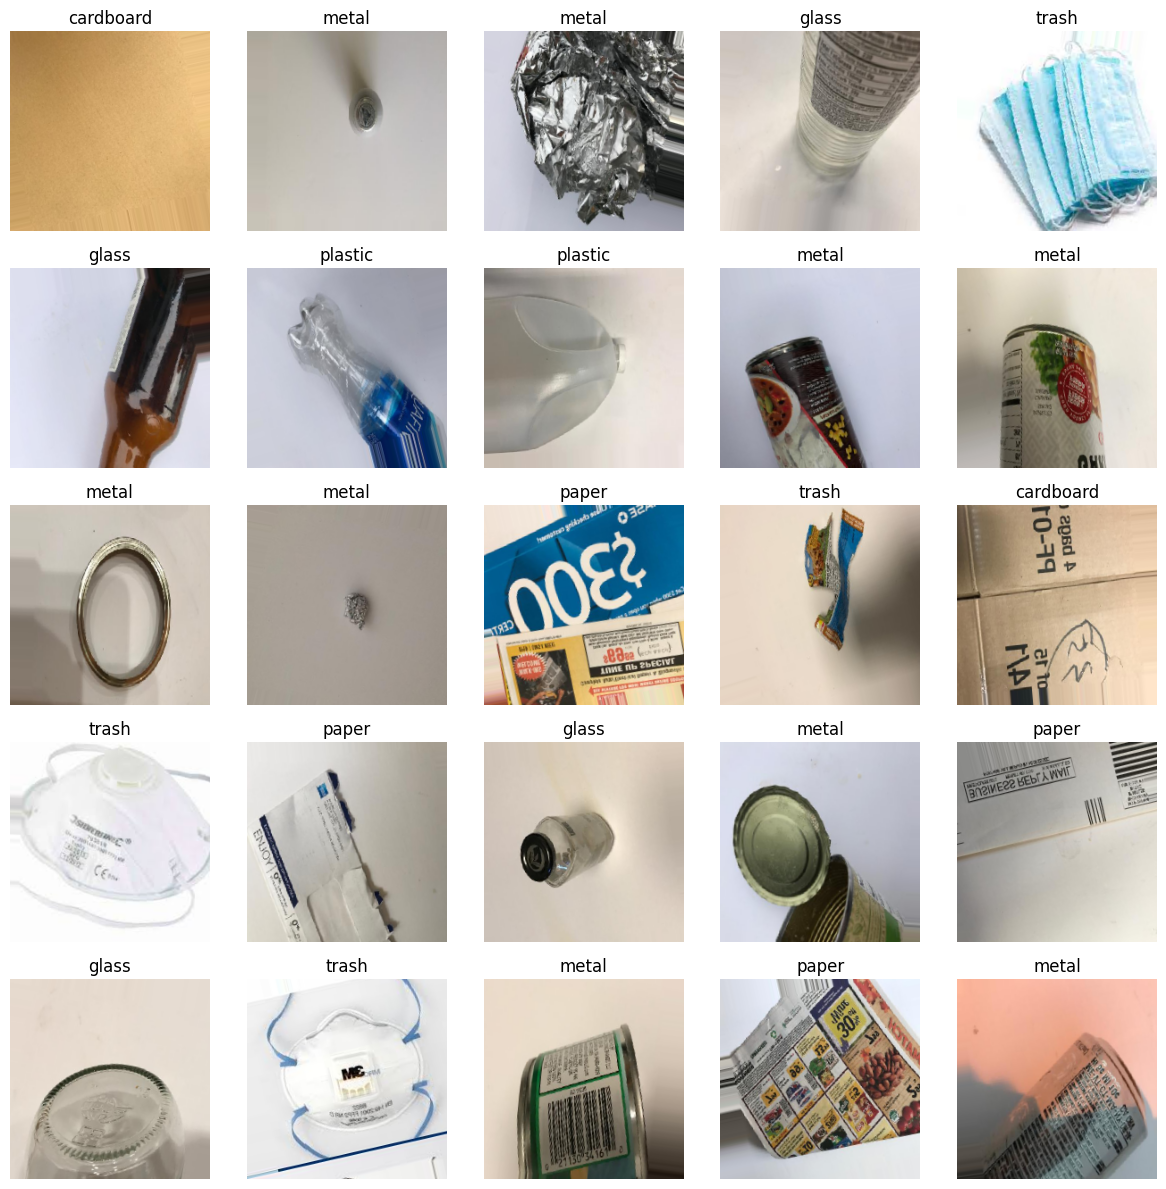

In [4]:
images, labels = next(train_generator)

# Ploting first 25 images
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    class_name = list(train_generator.class_indices.keys())[label_index]
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Check the Number of Images Per Class  Ensure Balance**

Class 'cardboard': 500 images
Class 'glass': 500 images
Class 'metal': 500 images
Class 'paper': 500 images
Class 'plastic': 500 images
Class 'trash': 500 images


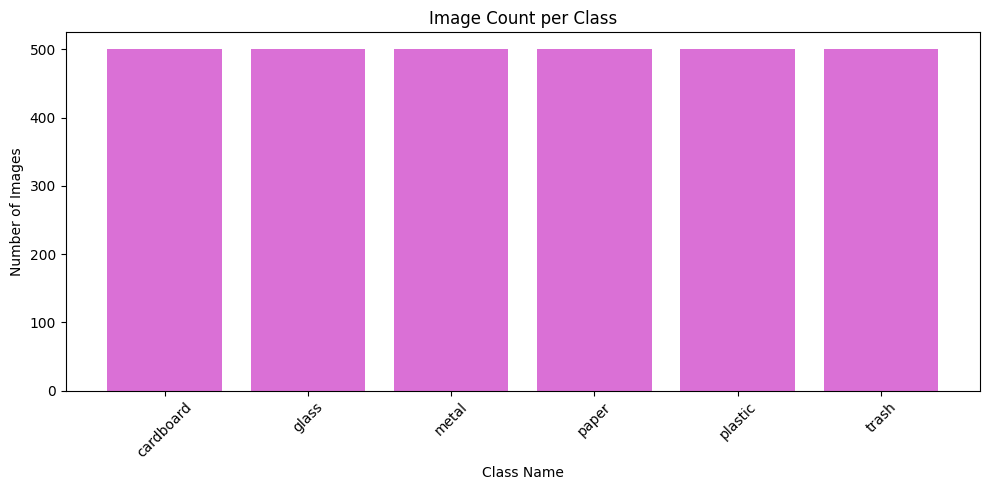

In [5]:
def count_images_per_class(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            count = len([
                fname for fname in os.listdir(class_dir)
                if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[class_name] = count
    return class_counts

class_counts = count_images_per_class(DATASET_PATH)

for cls, count in class_counts.items():
    print(f"Class '{cls}': {count} images")


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='orchid')
plt.title("Image Count per Class")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Model Selection**


In [6]:
# MobileNetV2 base model
base_model =MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
print(base_model.summary())

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

None


# Adding custom Layers

In [7]:
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

base_model.trainable = False
# for layer in base_model.layers[:-30]:  # Freeze all but last 30 layers
#     layer.trainable = False

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [8]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


# Callbacks including saving best model


In [9]:
callbacks = [
    ModelCheckpoint(
        filepath='best_mobilenetv2_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]


# Train the model


In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,

)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3350 - loss: 1.8283
Epoch 1: val_loss improved from inf to 0.78439, saving model to best_mobilenetv2_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 602s 8s/step - accuracy: 0.3368 - loss: 1.8231 - val_accuracy: 0.7167 - val_loss: 0.7844
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6521 - loss: 0.9400
Epoch 2: val_loss improved from 0.78439 to 0.66821, saving model to best_mobilenetv2_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.6524 - loss: 0.9392 - val_accuracy: 0.7433 - val_loss: 0.6682
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7206 - loss: 0.7513
Epoch 3: val_loss improved from 0.66821 to 0.64688, saving model to best_mobilenetv2_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.7207 - loss: 0.7511 - val_accuracy: 0.7533 - val_loss: 0.6469
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7620 - loss: 0.6550
Epoch 4: val_loss improved from 0

# Model Performance Visualization: Accuracy & Loss Trends


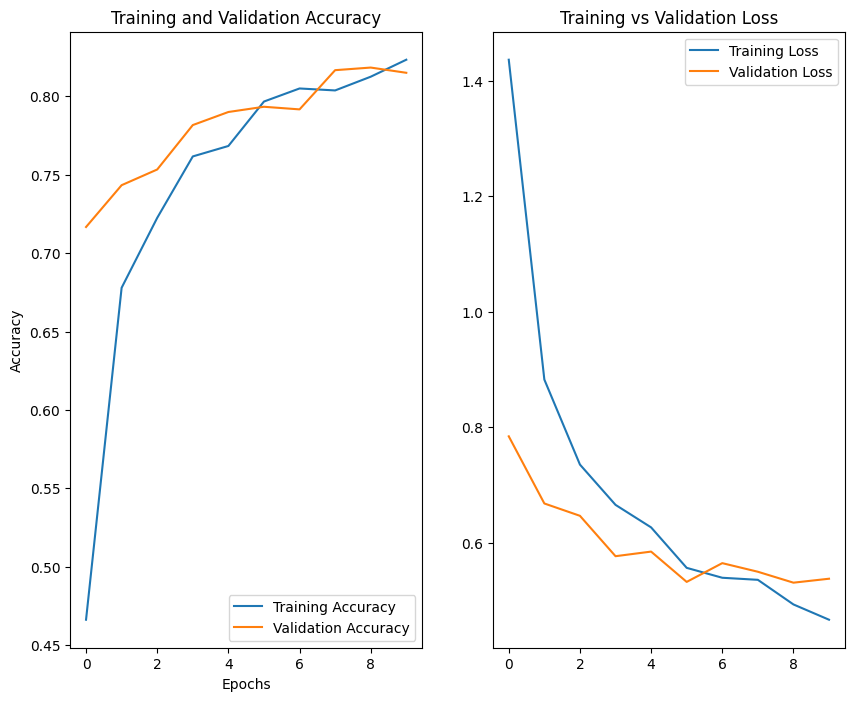

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


# Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Image 1: True = cardboard | Predicted = cardboard
Image 2: True = metal | Predicted = metal
Image 3: True = paper | Predicted = paper
Image 4: True = paper | Predicted = paper
Image 5: True = glass | Predicted = glass
Image 6: True = paper | Predicted = paper
Image 7: True = cardboard | Predicted = cardboard
Image 8: True = metal | Predicted = metal
Image 9: True = plastic | Predicted = plastic
Image 10: True = plastic | Predicted = plastic


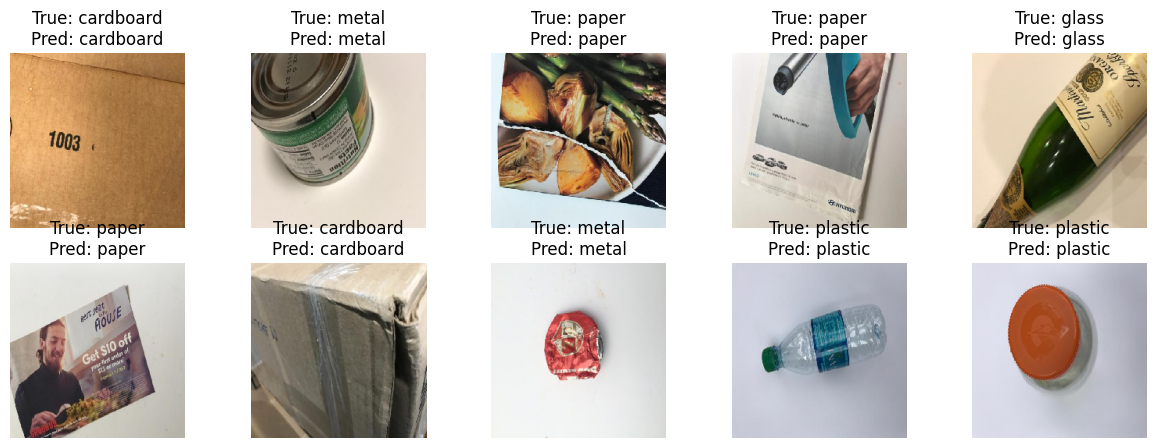

In [14]:
class_names = list(train_generator.class_indices.keys())
images, labels = next(test_generator)

# Limit to 10 images
images = images[:10]
labels = labels[:10]

# Predict
predictions = model.predict(images)

# Convert predictions & true labels to class names
predicted_classes = [class_names[np.argmax(p)] for p in predictions]
true_classes = [class_names[np.argmax(t)] for t in labels]

# Print results
for i in range(len(images)):
    print(f"Image {i+1}: True = {true_classes[i]} | Predicted = {predicted_classes[i]}")

plt.figure(figsize=(15,5))
for i in range(len(images)):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"True: {true_classes[i]}\nPred: {predicted_classes[i]}")
plt.show()